<a href="https://colab.research.google.com/github/KAFE45/Colab-LabBCI/blob/main/EEGTest01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mne pyxdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.3 MB/s eta 0:00:00


In [2]:
from google.colab import files

# อัปโหลดไฟล์ XDF
uploaded = files.upload()

# เลือกไฟล์ XDF ที่อัปโหลด
xdf_file = list(uploaded.keys())[0]

Saving sub-SSVEP01_ses-S001_task-Default_run-001_eeg.xdf to sub-SSVEP01_ses-S001_task-Default_run-001_eeg.xdf


In [3]:
import pyxdf

# โหลดไฟล์ XDF
streams, header = pyxdf.load_xdf('/content/sub-SSVEP01_ses-S001_task-Default_run-001_eeg.xdf')

# แสดงชื่อสตรีมทั้งหมด
for i, stream in enumerate(streams):
    print(f"Stream {i}: {stream['info']['name']}")

# ตรวจสอบข้อมูลในสตรีม EEG
eeg_stream = [s for s in streams if 'eeg' in s['info']['name']][0]
print("EEG Stream Info:")
print(f"Name: {eeg_stream['info']['name']}")
print(f"Shape: {eeg_stream['time_series'].shape}")
print(f"Sample Rate: {eeg_stream['info']['nominal_srate']} Hz")

# ตรวจสอบข้อมูลในสตรีม Markers
markers_stream = [s for s in streams if 'PsychoPyMarkers' in s['info']['name']][0]
print("Markers Stream Info:")
print(f"Name: {markers_stream['info']['name']}")
print(f"Shape: {markers_stream['time_series'].shape}")


Stream 0: ['eeg']
Stream 1: ['PsychoPyMarkers']
EEG Stream Info:
Name: ['eeg']
Shape: (39204, 24)
Sample Rate: ['256'] Hz
Markers Stream Info:
Name: ['PsychoPyMarkers']
Shape: (10, 1)


Markers from File 1:
Timestamp: 7152.10, Marker: 13
Timestamp: 7152.10, Marker: 2
Timestamp: 7182.10, Marker: 12
Timestamp: 7182.10, Marker: 3
Timestamp: 7212.12, Marker: 13
Timestamp: 7212.12, Marker: 4
Timestamp: 7242.13, Marker: 14
Timestamp: 7242.13, Marker: 3
Timestamp: 7272.13, Marker: 13
Timestamp: 7272.13, Marker: 1


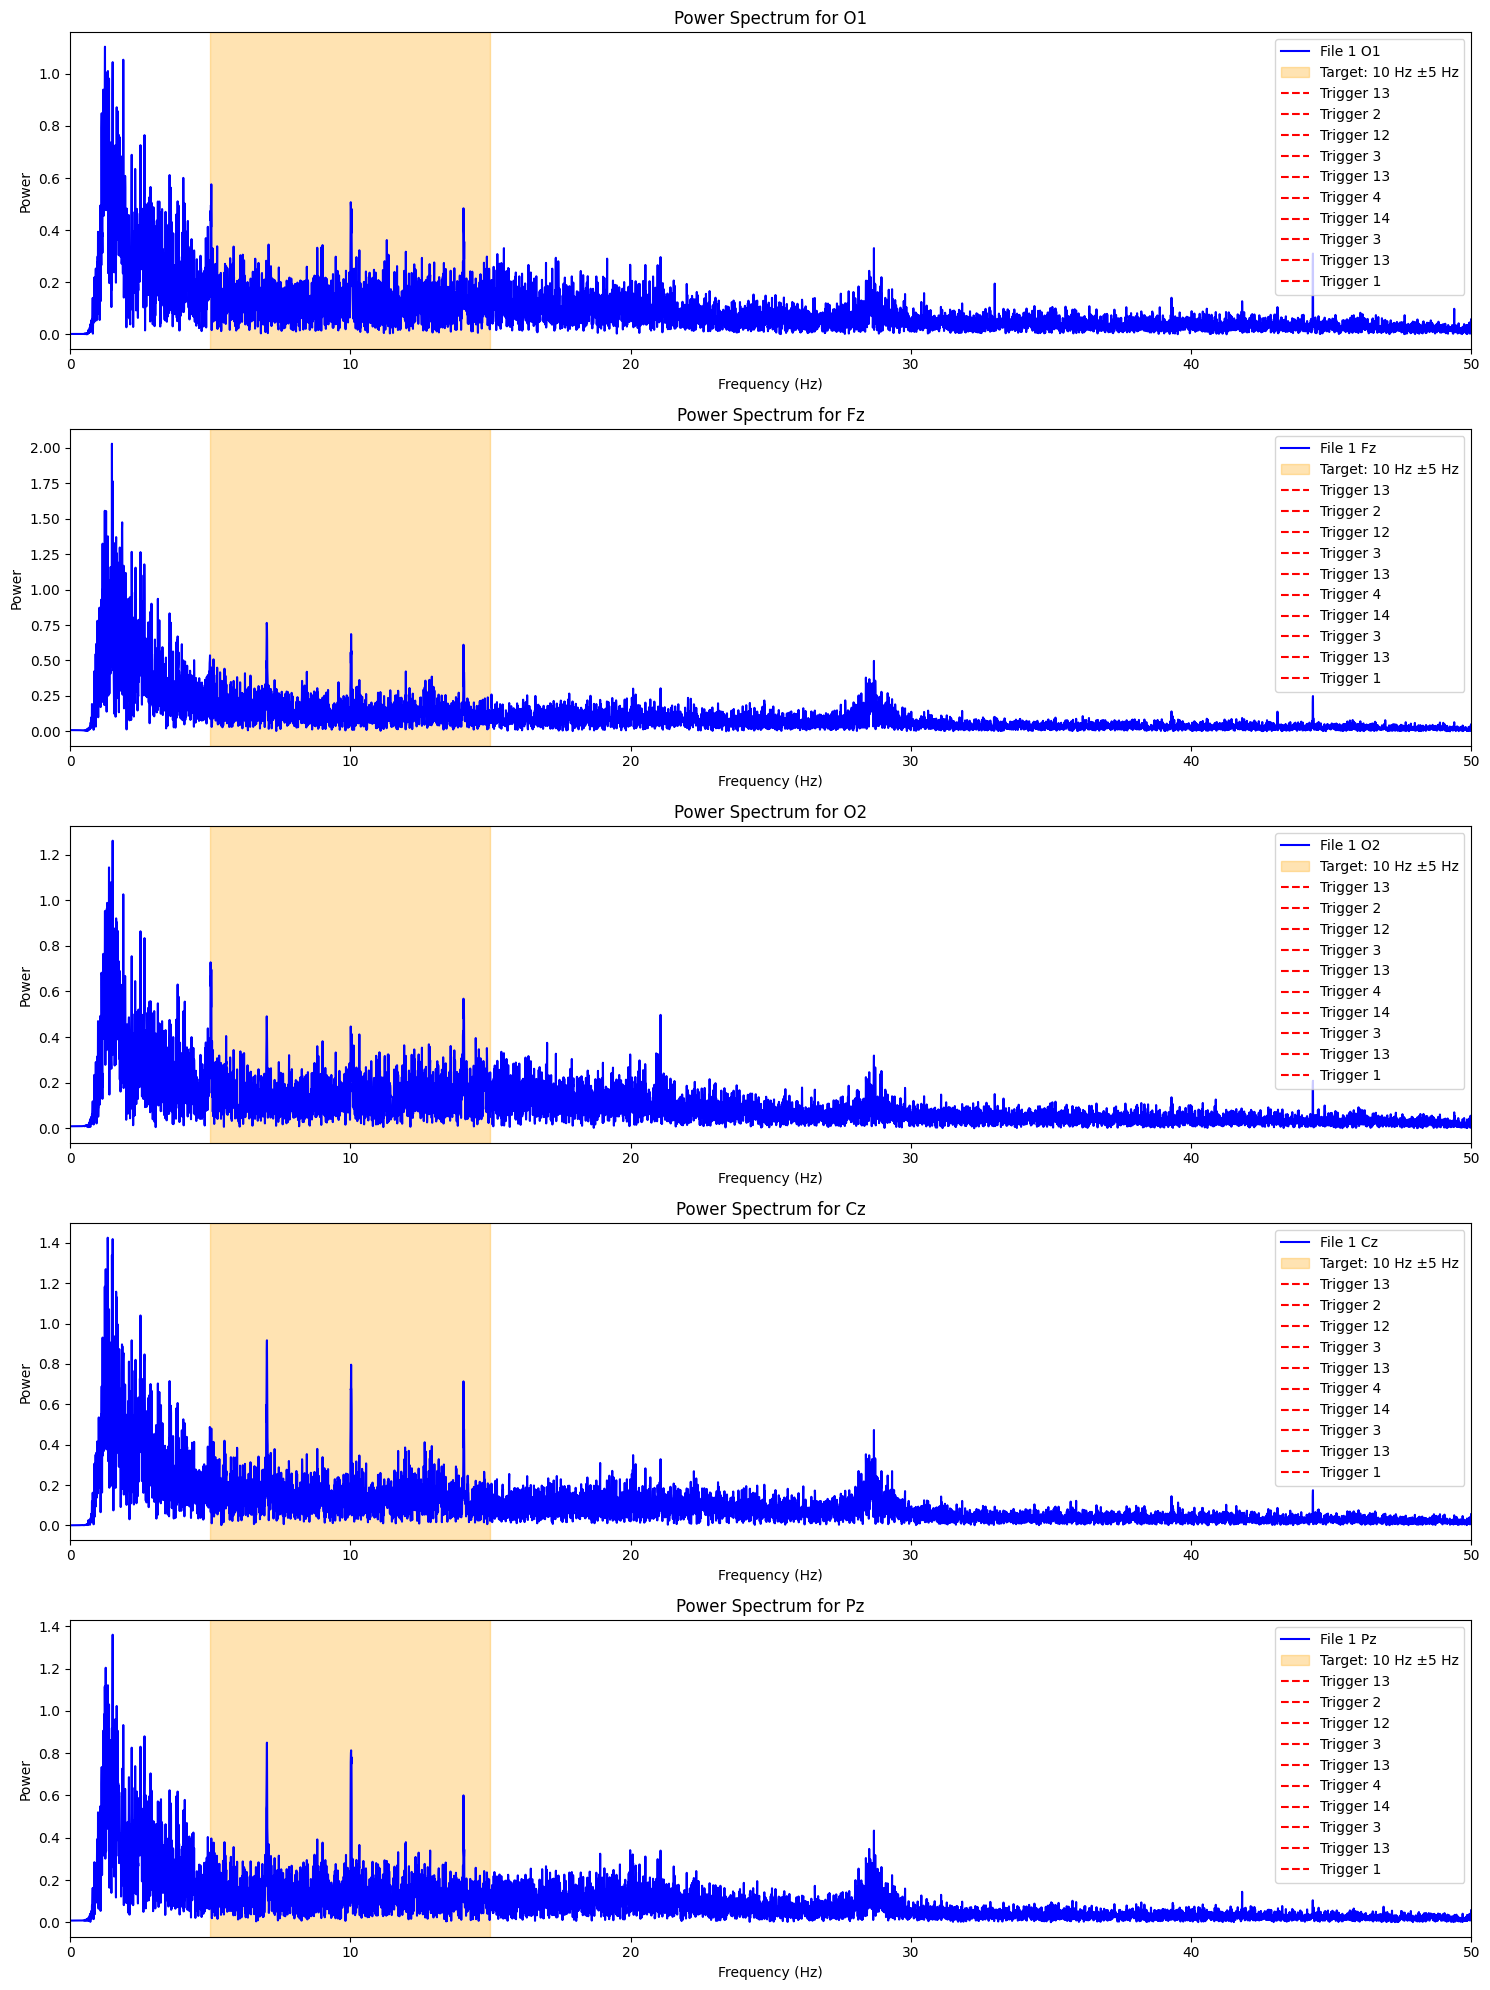

In [5]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt


from google.colab import files
import io

# # อัปโหลดไฟล์
# uploaded = files.upload()

# # ตรวจสอบชื่อไฟล์ที่อัปโหลดและอ่านไฟล์
# file_name = list(uploaded.keys())[0]  # เลือกไฟล์แรกที่อัปโหลด

# # Load the data จากไฟล์ที่อัปโหลด
# df1, sampling_rate1, markers1 = load_data(io.BytesIO(uploaded[file_name]))



# Load data from .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot Power Spectrum with FFT
def plot_power_spectrum_fft(df, sampling_rate, markers, channels, title_prefix, color='blue', target_freq=10, bandwidth=5):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # Apply bandpass filter if needed
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)  # Example: 1-50 Hz filtering

            # FFT of the filtered signal
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Plot power spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')

            # Set frequency range to 0-50 Hz
            plt.xlim(0, 50)

            # Highlight the target frequency range
            plt.axvspan(target_freq - bandwidth, target_freq + bandwidth, color='orange', alpha=0.3, label=f'Target: {target_freq} Hz ±{bandwidth} Hz')

            # Mark triggers with vertical lines in the frequency domain
            for timestamp, marker in markers:
                plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# # Load the data
df1, sampling_rate1, markers1 = load_data('/content/sub-SSVEP01_ses-S001_task-Default_run-001_eeg.xdf')


# Print the markers for debugging purposes
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Select the channels to plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']

# Plot the power spectrum using FFT for the first file
plot_power_spectrum_fft(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', target_freq=10)

# Show the plot
plt.show()


Markers from File 1:
Timestamp: 7152.10, Marker: 13
Timestamp: 7152.10, Marker: 2
Timestamp: 7182.10, Marker: 12
Timestamp: 7182.10, Marker: 3
Timestamp: 7212.12, Marker: 13
Timestamp: 7212.12, Marker: 4
Timestamp: 7242.13, Marker: 14
Timestamp: 7242.13, Marker: 3
Timestamp: 7272.13, Marker: 13
Timestamp: 7272.13, Marker: 1


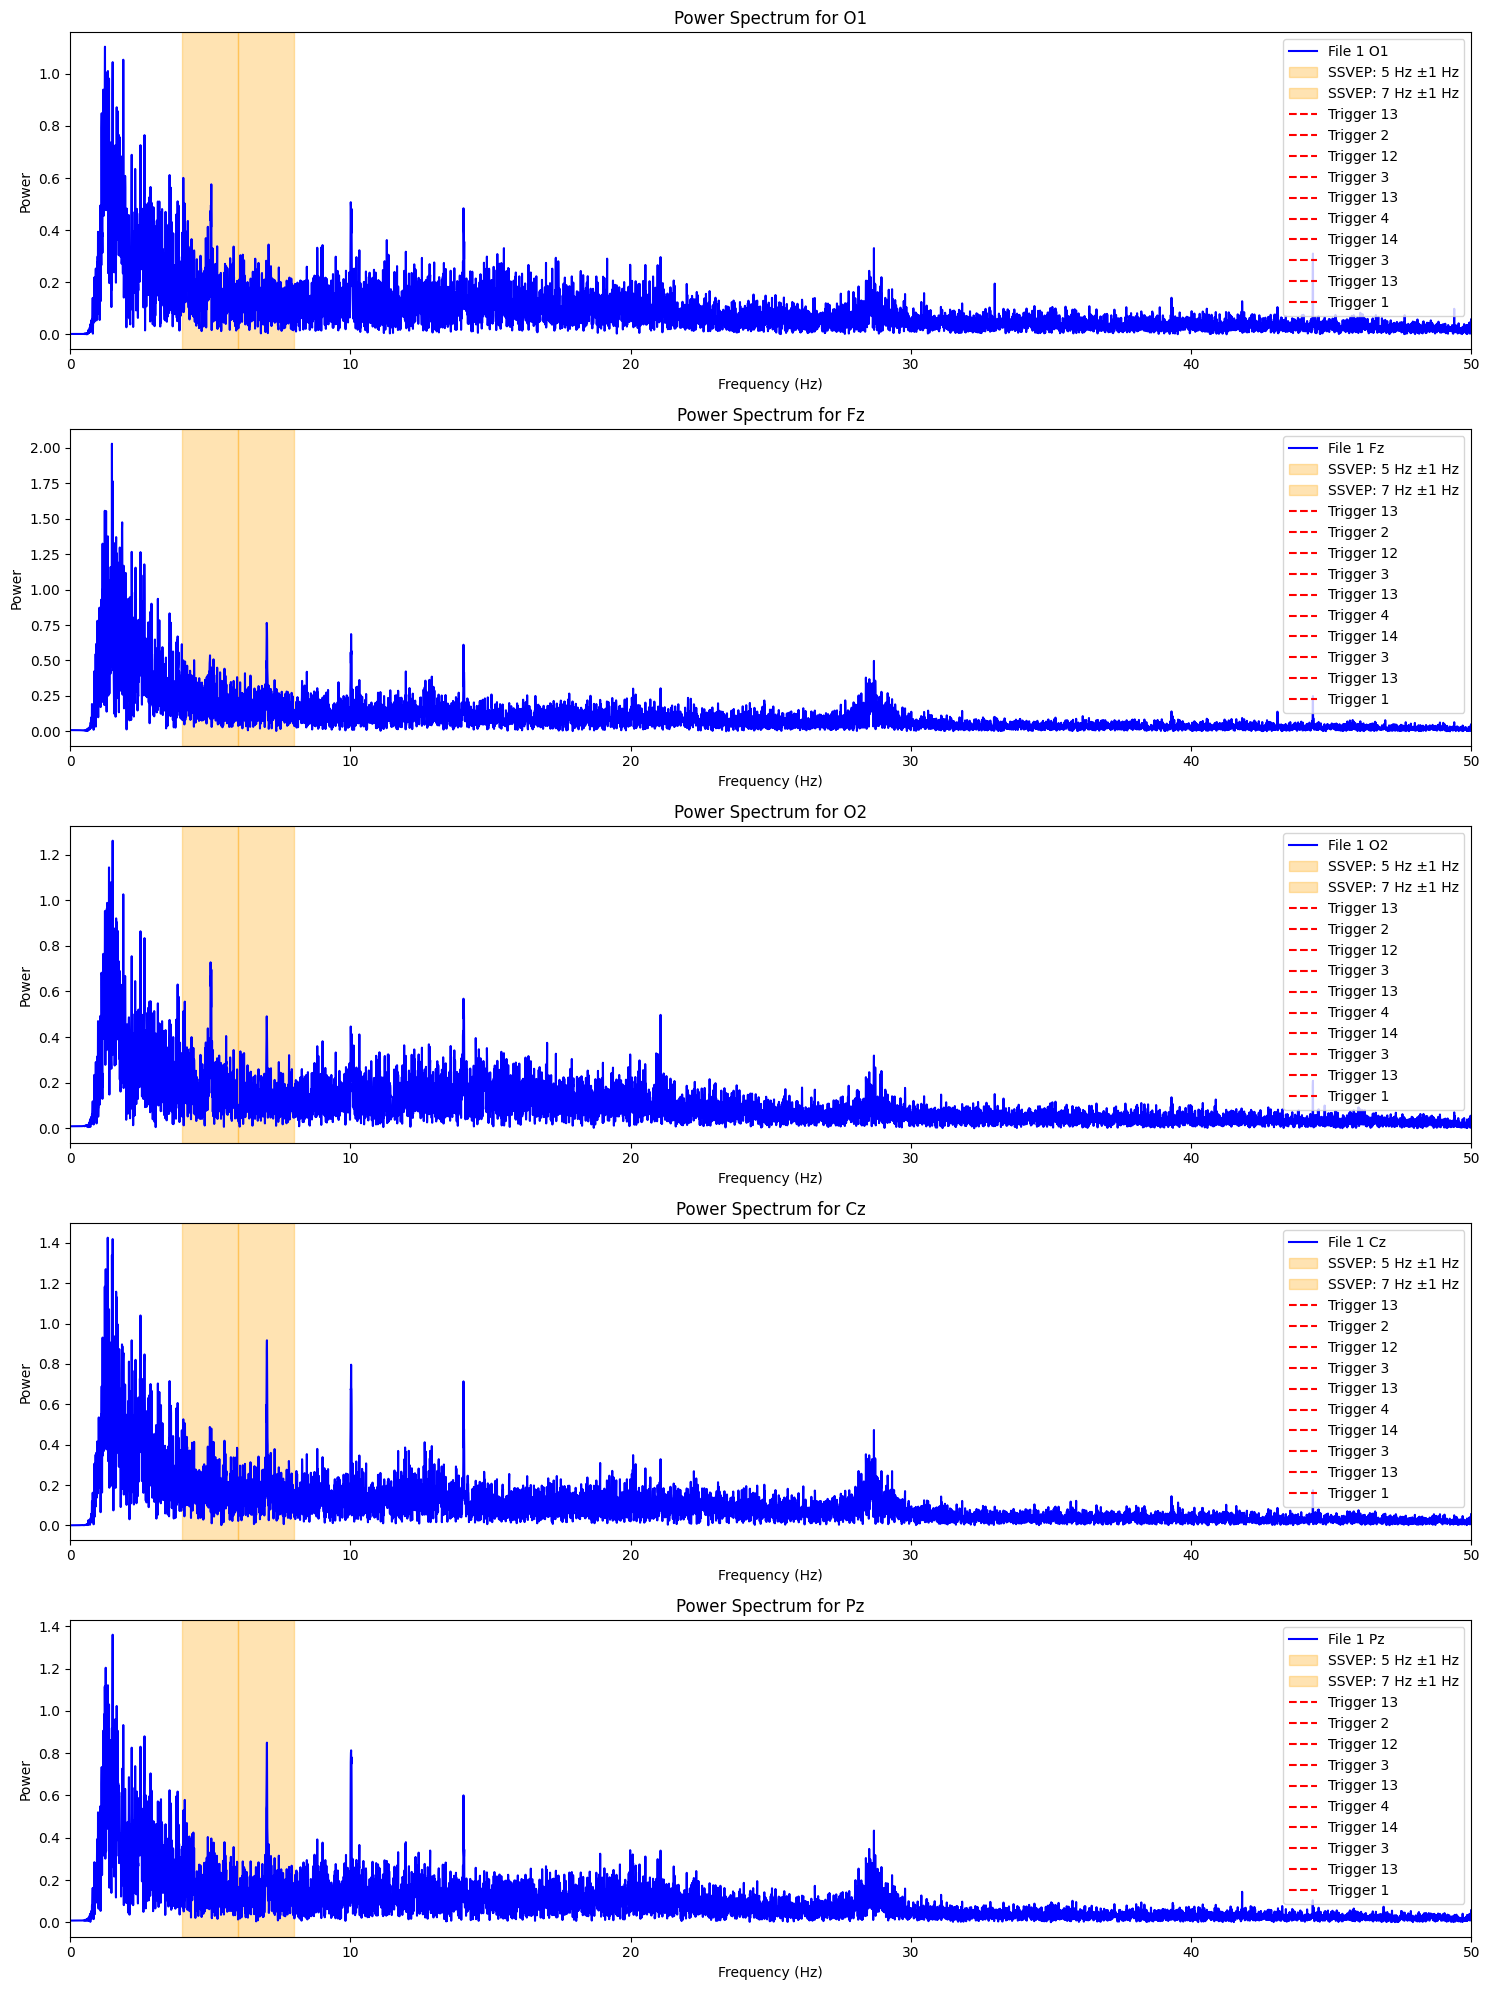

In [6]:
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, filtfilt


# Load data from .xdf file
def load_data(filepath):
    streams, header = pyxdf.load_xdf(filepath)

    eeg_stream = None
    marker_stream = None
    for stream in streams:
        if stream['info']['name'][0] == 'eeg' and stream['info']['type'][0] == 'signal':
            eeg_stream = stream
        elif stream['info']['type'][0] == 'Markers':
            marker_stream = stream

    if eeg_stream is None:
        raise ValueError(f"ไม่พบ stream ชื่อ 'eeg' ในไฟล์ {filepath}")

    data = eeg_stream['time_series']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    channel_names = eeg_stream['info']['desc'][0]['channels'][0]['channel']
    channel_labels = [chan['label'][0] for chan in channel_names]

    df = pd.DataFrame(data, columns=channel_labels)

    markers = []
    if marker_stream:
        marker_times = marker_stream['time_stamps']
        marker_values = marker_stream['time_series']
        markers = list(zip(marker_times, marker_values))

    return df, sampling_rate, markers

# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Plot Power Spectrum with FFT for SSVEP (5 Hz and 7 Hz)
def plot_power_spectrum_ssvep(df, sampling_rate, markers, channels, title_prefix, color='blue', ssvep_frequencies=[5, 7], bandwidth=1):
    plt.figure(figsize=(15, 20))

    for i, channel in enumerate(channels):
        if channel in df.columns:
            signal = df[channel].values

            # Apply bandpass filter if needed (1-50 Hz filtering as example)
            filtered_signal = bandpass_filter(signal, 1, 50, sampling_rate)

            # FFT of the filtered signal
            N = len(filtered_signal)
            T = 1.0 / sampling_rate
            yf = fft(filtered_signal)
            xf = np.fft.fftfreq(N, T)[:N // 2]
            power_spectrum = 2.0 / N * np.abs(yf[:N // 2])

            # Plot power spectrum
            plt.subplot(len(channels), 1, i + 1)
            plt.plot(xf, power_spectrum, color=color, label=f'{title_prefix} {channel}')
            plt.title(f'Power Spectrum for {channel}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')

            # Set frequency range to 0-50 Hz
            plt.xlim(0, 50)

            # Highlight the target SSVEP frequencies (5 Hz and 7 Hz)
            for freq in ssvep_frequencies:
                plt.axvspan(freq - bandwidth, freq + bandwidth, color='orange', alpha=0.3, label=f'SSVEP: {freq} Hz ±{bandwidth} Hz')

            # Mark triggers with vertical lines in the time domain
            for timestamp, marker in markers:
                plt.axvline(x=timestamp, color='red', linestyle='--', label=f'Trigger {marker[0]}')

            plt.legend()
        else:
            print(f'Warning: {channel} not found in data columns.')

    plt.tight_layout()

# Load the data
df1, sampling_rate1, markers1 = load_data('/content/sub-SSVEP01_ses-S001_task-Default_run-001_eeg.xdf')

# Print the markers for debugging purposes
print("Markers from File 1:")
for timestamp, marker in markers1:
    print(f"Timestamp: {timestamp:.2f}, Marker: {marker[0]}")

# Select the channels to plot
channels = ['O1', 'Fz', 'O2', 'Cz', 'Pz']

# Plot the power spectrum for SSVEP frequencies (5 Hz and 7 Hz)
plot_power_spectrum_ssvep(df1, sampling_rate1, markers1, channels, 'File 1', color='blue', ssvep_frequencies=[5, 7], bandwidth=1)

# Show the plot
plt.show()


Saving sub-baseline_ses-test01_task-Default_run-001_eeg.xdf to sub-baseline_ses-test01_task-Default_run-001_eeg (1).xdf


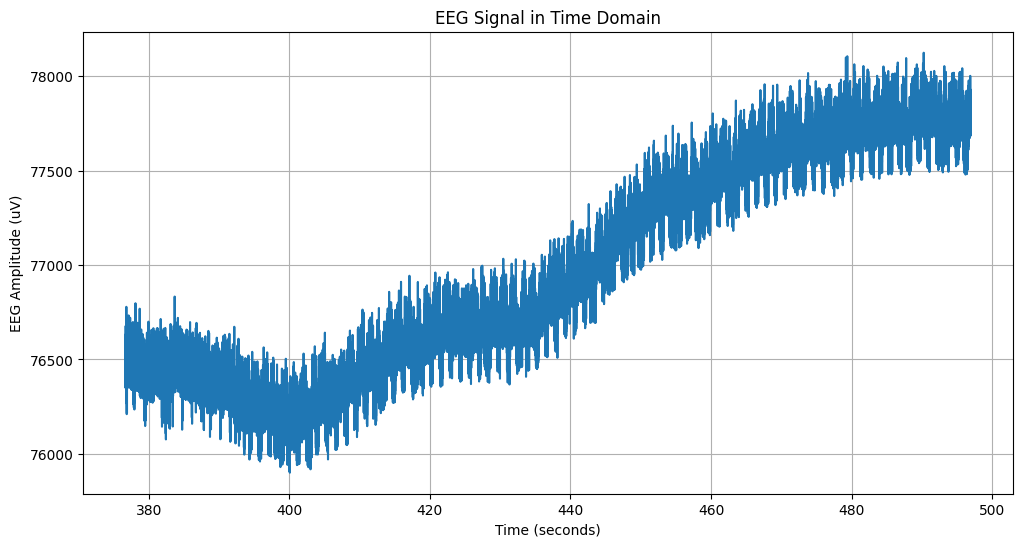

In [ ]:
# ขั้นตอนที่ 1: ติดตั้งไลบรารีที่จำเป็น
!pip install pyxdf matplotlib

# ขั้นตอนที่ 2: อัปโหลดไฟล์ XDF
from google.colab import files
uploaded = files.upload()

# ขั้นตอนที่ 3: อ่านข้อมูลจากไฟล์ XDF
import pyxdf
import numpy as np
import matplotlib.pyplot as plt

# โหลดไฟล์ XDF (สมมติว่าไฟล์ชื่อ 'example.xdf')
xdf_file = list(uploaded.keys())[0]

# อ่านไฟล์ XDF
streams, header = pyxdf.load_xdf(xdf_file)

# ขั้นตอนที่ 4: เลือกสตรีมสัญญาณ EEG (สมมติว่าเป็นสตรีมแรก)
eeg_stream = streams[0]  # เลือกสตรีมที่บันทึกสัญญาณ EEG
eeg_data = eeg_stream['time_series']  # ข้อมูลสัญญาณ EEG
timestamps = eeg_stream['time_stamps']  # เวลาที่แต่ละข้อมูลถูกบันทึก
sample_rate = float(eeg_stream['info']['nominal_srate'][0])  # อัตราการสุ่มตัวอย่าง

# ขั้นตอนที่ 5: เลือกช่องสัญญาณ EEG ที่ต้องการ (สมมติว่าเป็นช่องแรก)
eeg_channel = eeg_data[:, 0]  # เลือกข้อมูลช่องแรกของ EEG

# ขั้นตอนที่ 6: แสดงผลกราฟเวลา (Time Domain) ของสัญญาณ EEG
plt.figure(figsize=(12, 6))
plt.plot(timestamps, eeg_channel)
plt.title('EEG Signal in Time Domain')
plt.xlabel('Time (seconds)')
plt.ylabel('EEG Amplitude (uV)')
plt.grid(True)
plt.show()


In [ ]:
!pip install  mne
!pip install  numpy

import os
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw = raw.pick_types(meg=False, eeg=True, eog=False, exclude='bads')

print(raw.info)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.4 MB/s eta 0:00:00
Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.18TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 06m28s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 13 non-empty values
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 59
 projs: Average EEG reference: off
 sfreq: 1

Using matplotlib as 2D backend.


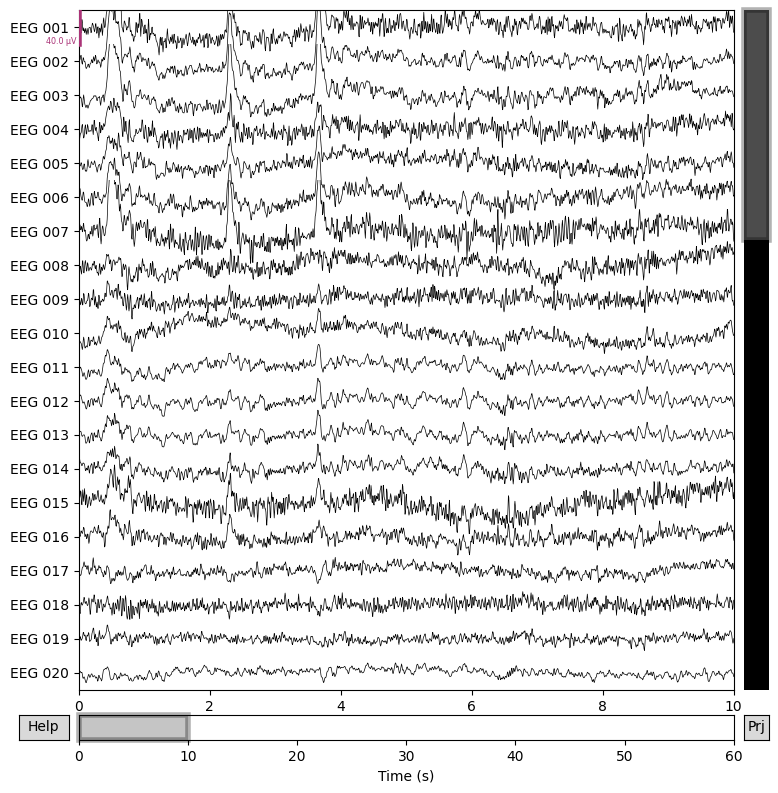

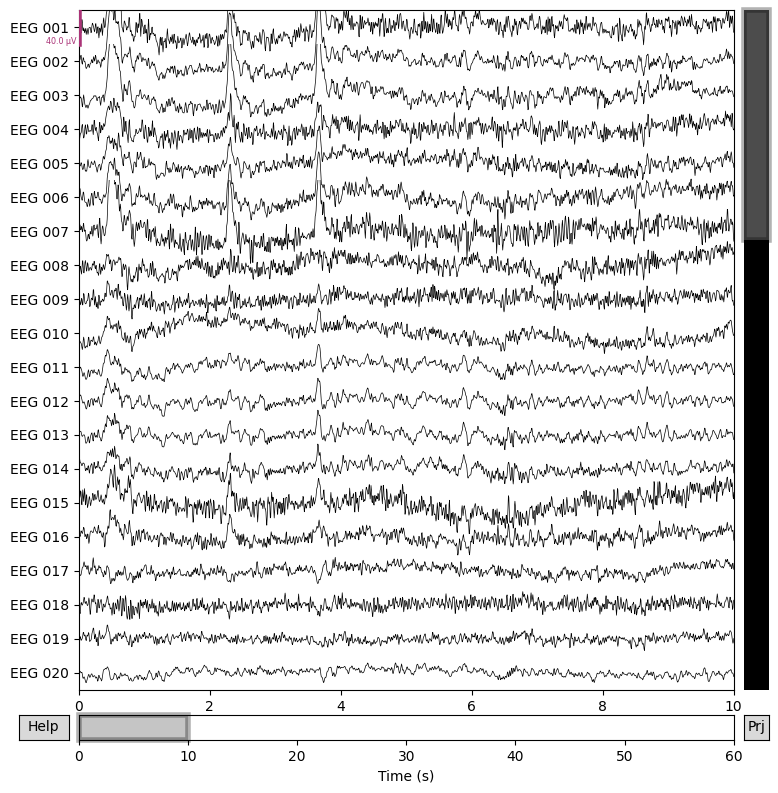

In [ ]:
raw.crop(0, 60) # keeps the first minute of data and discards the rest
raw.plot()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


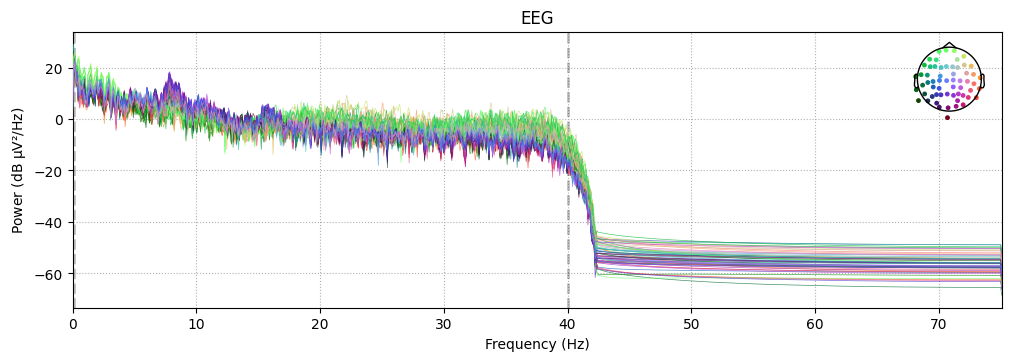

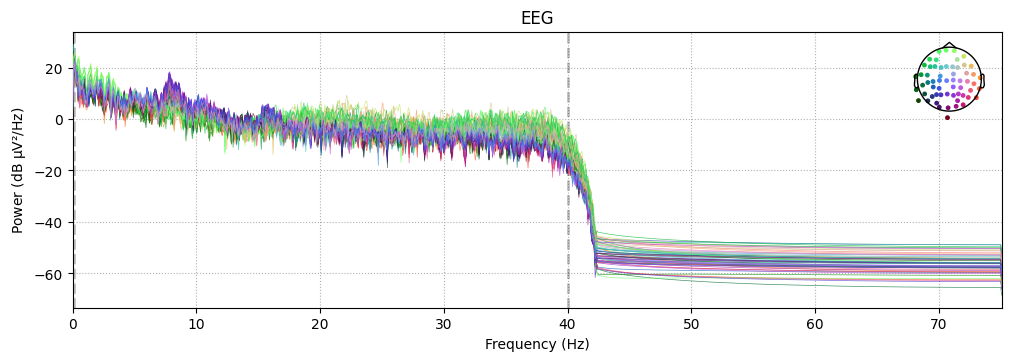

In [ ]:
raw.plot_psd()

## เริ่ม Passt **ทดลอง** Data:

In [ ]:
!pip install pyxdf
!pip install mne
!pip install numpy

In [ ]:
import os
import numpy as np
import mne
import pyxdf

# โหลดไฟล์ XDF
xdf_file = '/content/sub-testEEG_ses-testeegonly_task-Default_run-001_eeg.xdf'
streams, header = pyxdf.load_xdf(xdf_file)

# ตรวจสอบ streams ในไฟล์ XDF
for stream in streams:
    print(f"Stream Name: {stream['info']['name'][0]}")
    print(f"Stream Type: {stream['info']['type'][0]}")
    print(f"Stream Shape: {stream['time_series'].shape}")
    print()

# หา stream ที่เป็น EEG
eeg_stream = None
for stream in streams:
    if 'EEG' in stream['info']['type'][0]:
        eeg_stream = stream
        break

if eeg_stream is None:
    print("ไม่พบข้อมูล EEG ในไฟล์ XDF")
else:
    # แปลงข้อมูล EEG เป็น array
    eeg_data = np.array(eeg_stream['time_series']).T  # ทำการ transpose เนื่องจากข้อมูลใน XDF จะมีรูปแบบ (samples, channels)

    # สร้างข้อมูลในรูปแบบ RawArray เพื่อใช้กับ MNE
    info = mne.create_info(ch_names=[f"EEG{i}" for i in range(eeg_data.shape[0])], sfreq=float(eeg_stream['info']['nominal_srate'][0]), ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    # แสดงข้อมูลของ raw
    print(raw.info)


Stream Name: eeg
Stream Type: signal
Stream Shape: (30792, 24)

ไม่พบข้อมูล EEG ในไฟล์ XDF


Saving sub-testttt_ses-gfdgfdgdfgfdgfdgfdg_task-Default_run-001_eeg.xdf to sub-testttt_ses-gfdgfdgdfgfdgfdgfdg_task-Default_run-001_eeg (1).xdf
Stream Name: openvibeMarkers
Stream Type: Markers
Stream Shape: (1, 0)

Stream Name: openvibeSignal
Stream Type: signal
Stream Shape: (42800, 24)

Stream Name: eeg
Stream Type: signal
Stream Shape: (42748, 24)

Stream Name: openvibeMarkers
Stream Type: Markers
Stream Shape: (1, 0)

Stream Name: PsychoPyMarkers
Stream Type: Markers
Stream Shape: (1, 0)

ไม่พบข้อมูล EEG ในไฟล์ XDF


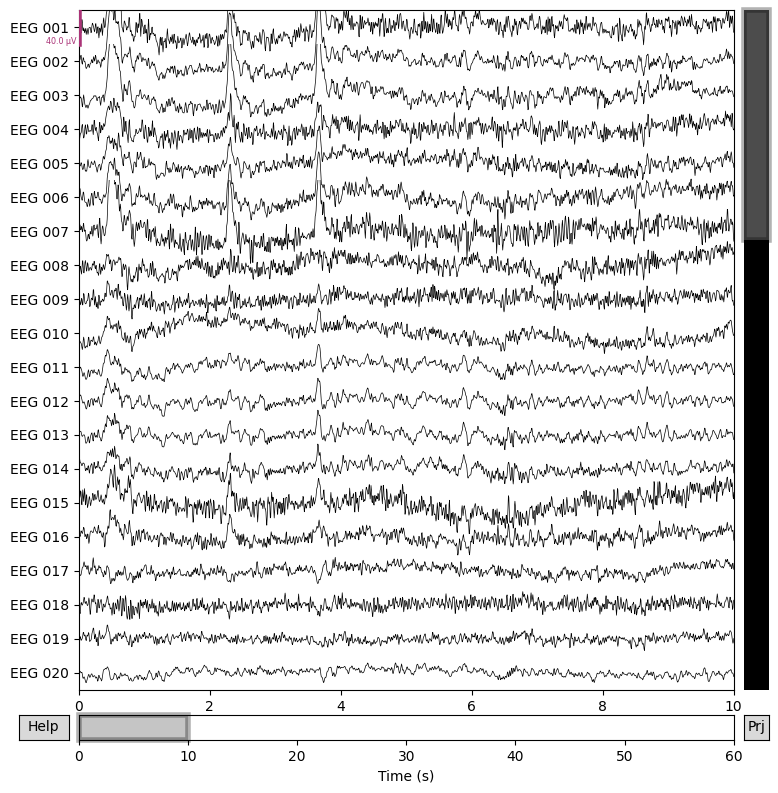

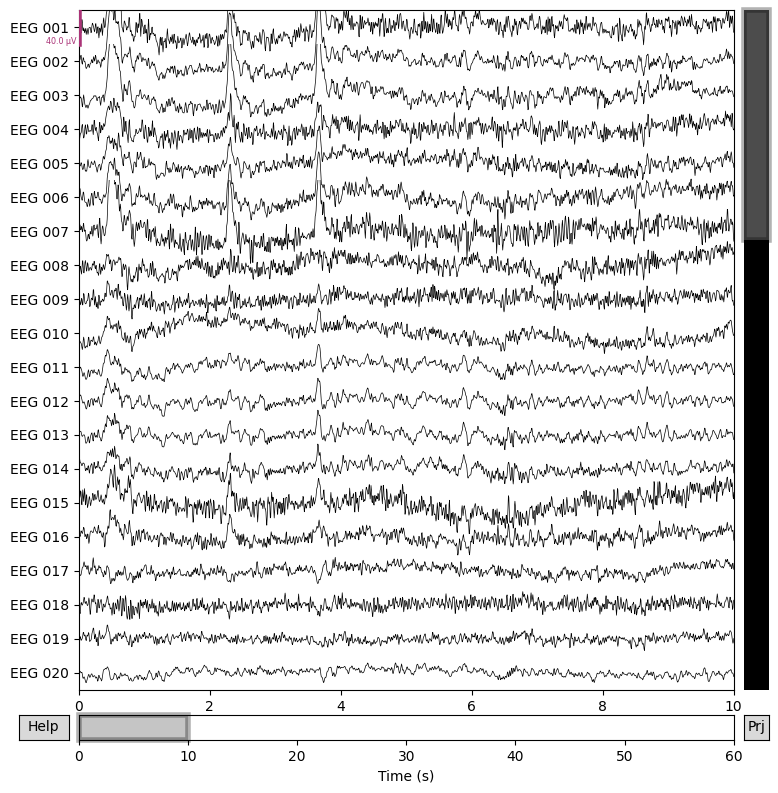

In [ ]:
import numpy as np
import mne
import pyxdf
from google.colab import files

# ขั้นตอนที่ 2: อัปโหลดไฟล์ XDF
uploaded = files.upload()

# เลือกไฟล์ XDF ที่อัปโหลด
xdf_file = list(uploaded.keys())[0]

# ขั้นตอนที่ 3: อ่านข้อมูลจากไฟล์ XDF
streams, header = pyxdf.load_xdf(xdf_file)

# ตรวจสอบ streams ในไฟล์ XDF
for stream in streams:
    print(f"Stream Name: {stream['info']['name'][0]}")
    print(f"Stream Type: {stream['info']['type'][0]}")
    print(f"Stream Shape: {stream['time_series'].shape}")
    print()

# หา stream ที่เป็น EEG
eeg_stream = None
for stream in streams:
    if 'EEG' in stream['info']['type'][0]:
        eeg_stream = stream
        break

if eeg_stream is None:
    print("ไม่พบข้อมูล EEG ในไฟล์ XDF")
else:
    # แปลงข้อมูล EEG เป็น array
    eeg_data = np.array(eeg_stream['time_series']).T  # ทำการ transpose เนื่องจากข้อมูลใน XDF จะมีรูปแบบ (samples, channels)

    # สร้างข้อมูลในรูปแบบ RawArray เพื่อใช้กับ MNE
    info = mne.create_info(ch_names=[f"EEG{i}" for i in range(eeg_data.shape[0])], sfreq=float(eeg_stream['info']['nominal_srate'][0]), ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    # แสดงข้อมูลของ raw
    print(raw.info)

    raw.crop(0, 60) # keeps the first minute of data and discards the rest
raw.plot()
